In [18]:
import inspect
from typing import List

from tensorflow.keras import backend as K, Model, Input, optimizers
# pylint: disable=E0611
from tensorflow.keras import layers
# pylint: disable=E0611
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
# pylint: disable=E0611
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization
import tensorflow

class SE_Block(Layer):
    def __init__(self,reduction = 16,**kwargs):
        super(SE_Block,self).__init__(**kwargs)
        tensorflow.config.run_functions_eagerly(True)
        self.reduction = reduction
    def build(self, input_shape):
        pass
    @tensorflow.function
    def call(self, inputs):
        num_filters = inputs.shape[-1]
        squeeze = tensorflow.keras.layers.GlobalAveragePooling1D()(inputs)

        excitation = tensorflow.keras.layers.Dense(units=num_filters/self.reduction)(squeeze)
        excitation = tensorflow.keras.layers.Activation('relu')(excitation)
        excitation = tensorflow.keras.layers.Dense(units=num_filters)(excitation)
        excitation = tensorflow.keras.layers.Activation('sigmoid')(excitation)
        excitation = tensorflow.keras.layers.Reshape([1, num_filters])(excitation)

        scale = inputs * excitation

        return scale


def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):  # dilated conv block.
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                with K.name_scope('act_and_dropout_{}'.format(k)):
                    self._build_layer(Activation(self.activation, name='Act_Conv1D_{}'.format(k)))
                    self._build_layer(SpatialDropout1D(rate=self.dropout_rate, name='SDropout_{}'.format(k)))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape.
                    # 1x1 conv.
                    self.shape_match_conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=1,
                        padding='same',
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation, name='Act_Conv_Blocks'))
            self.final_activation = Activation(self.activation, name='Act_Res_Block')
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None, **kwargs):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        # https://arxiv.org/pdf/1803.01271.pdf  page 4, Figure 1 (b).
        # x1: Dilated Conv -> Norm -> Dropout (x2).
        # x2: Residual (1x1 matching conv - optional).
        # Output: x1 + x2.
        # x1 -> connected to skip connections.
        # x1 + x2 -> connected to the next block.
        #       input
        #     x1      x2
        #   conv1D    1x1 Conv1D (optional)
        #    ...
        #   conv1D
        #    ...
        #       x1 + x2
        x1 = inputs
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x1 = layer(x1, training=training) if training_flag else layer(x1)
        x1 = SE_Block(reduction=16)(x1)

        # print('x1.shape = ',x1.shape)
        x2 = self.shape_match_conv(inputs)
        x1_x2 = self.final_activation(layers.add([x2, x1], name='Add_Res'))
        return [x1_x2, x1]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]


class TCN(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=3,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)
            if len(set(self.nb_filters)) > 1 and self.use_skip_connections:
                raise ValueError('Skip connections are not compatible '
                                 'with a list of filters, unless they are all equal.')

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        return 1 + 2 * (self.kernel_size - 1) * self.nb_stacks * sum(self.dilations)

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :], name='Slice_Output')
        self.slicer_layer.build(self.build_output_shape.as_list())

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None, **kwargs):
        x = inputs
        self.layers_outputs = [x]
        self.skip_connections = []
        for res_block in self.residual_blocks:
            try:
                x, skip_out = res_block(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = res_block(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            x = layers.add(self.skip_connections, name='Add_Skip_Connections')
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        return config

In [19]:
def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 output_len=1,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=False,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 kernel_initializer='he_normal',  # type: str,
                 activation='relu',  # type:str,
                 opt='adam',
                 learning_rate=0.002,
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False):
    # type: (...) -> Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.
    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        activation: The activation used in the residual blocks o = Activation(x + F(x)).
        name: Name of the model. Useful when having multiple TCN.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        opt: Optimizer name.
        lr: Learning rate.
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
        use_layer_norm: Whether to use layer normalization in the residual layers or not.
        use_weight_norm: Whether to use weight normalization in the residual layers or not.
    Returns:
        A compiled keras TCN.
    """


    dilations = adjust_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences,
            activation, kernel_initializer, use_batch_norm, use_layer_norm,
            use_weight_norm, name=name)(input_layer)

    print('x.shape=', x.shape)

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(learning_rate=learning_rate, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(learning_rate=learning_rate, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        model.compile(get_opt(), loss='categorical_crossentropy', metrics=["accuracy"]) # sparse_categorical_crossentropy [1] [2]
    else:
        # regression
        x = Dense(output_len)(x)
        x = Activation('linear')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error', metrics=["accuracy"])
    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))
    return model


def tcn_full_summary(model: Model, expand_residual_blocks=True):
    import tensorflow as tf
    # 2.6.0-rc1, 2.5.0...
    versions = [int(v) for v in tf.__version__.split('-')[0].split('.')]
    if versions[0] <= 2 and versions[1] < 5:
        layers = model._layers.copy()  # store existing layers
        model._layers.clear()  # clear layers

        for i in range(len(layers)):
            if isinstance(layers[i], TCN):
                for layer in layers[i]._layers:
                    if not isinstance(layer, ResidualBlock):
                        if not hasattr(layer, '__iter__'):
                            model._layers.append(layer)
                    else:
                        if expand_residual_blocks:
                            for lyr in layer._layers:
                                if not hasattr(lyr, '__iter__'):
                                    model._layers.append(lyr)
                        else:
                            model._layers.append(layer)
            else:
                model._layers.append(layers[i])

        model.summary()  # print summary

        # restore original layers
        model._layers.clear()
        [model._layers.append(lyr) for lyr in layers]
    else:
        print('WARNING: tcn_full_summary: Compatible with tensorflow 2.5.0 or below.')
        print('Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.')

In [20]:
# Dataset
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import numpy
import plotly.graph_objects as go
import tensorflow



class Gear_Dataset:
    def __init__(self,
                 filepath = 'C:/Users/user/Desktop/TCN/資料擷取/資料擷取_npy/mid',
                 series_length = 10240,
                 scale_method = None,
                 shuffle = True,
                 random_seed = None,
                 verbose = True
                 ):

        self.filepath = filepath
        self.series_length = series_length
        self.scale_method = scale_method
        self.train_data = None
        self.label_data = None
        self.classification_dataset = None
        self.regression_dataset = None
        self.shuffle = shuffle
        self.random_seed = random_seed
        self.verbose = verbose

        self.__get_dataset()

    @staticmethod
    def __scale_data(data, scale_method = None, verbose = True):
        scaler = scale_method
        series = scaler.fit_transform(data)
        if verbose:
            line = go.Scatter(y = data[:, 0][:10240], name = "original")
            scale_line = go.Scatter(y = series[:, 0][:10240], name = "scale line")
            go.Figure([line, scale_line]).show()
        return series

    @staticmethod
    def __get_data_number(datas):
        data_shape = []
        for data in datas:
            data_shape.append(data.shape[0])
        return data_shape

    @staticmethod
    def __create_label(label_shape_list):
        label_list = []
        for label_num in range(len(label_shape_list)):
            for _ in range(label_shape_list[label_num]):
                label_list.append(label_num)

        return to_categorical(label_list, len(label_shape_list))

    def __load_data(self, filepath, scale_method = None):
        GOOD = numpy.load(f'{filepath}/Good.npy')
        BC = numpy.load(f'{filepath}/BC.npy')
        LOOSE = numpy.load(f'{filepath}/Loose.npy')
        SHAFT = numpy.load(f'{filepath}/Shaft.npy')
        TOOTH_BREAK = numpy.load(f'{filepath}/Tooth Break.npy')
        WEAR = numpy.load(f'{filepath}/Wear.npy')
        datas_list = [GOOD, BC, LOOSE, SHAFT, TOOTH_BREAK, WEAR]
        if scale_method is not None:
            scale_datas_list = []
            for data in datas_list:
                scale_datas_list.append(self.__scale_data(data, scale_method=scale_method, verbose=self.verbose))
            return scale_datas_list

        return datas_list

    def __get_gear_data(self, filepath, series_length = 10240, scale_method = None):
        all_data = self.__load_data(filepath, scale_method)
        reshape_data = []
        for data in all_data:
            reshape_data.append(data.reshape(-1, series_length, 3))
        gear_labels = self.__create_label(self.__get_data_number(reshape_data))
        gear_train = numpy.concatenate(reshape_data)
        return gear_train, gear_labels

    def split_dataset(self, tf_dataset, split = 8):
        test_dataset = tf_dataset.enumerate().filter(lambda x,y: x%10== split).map(lambda x,y: y)
        val_dataset = tf_dataset.enumerate().filter(lambda x,y: x%10> split).map(lambda x,y: y)
        train_dataset = tf_dataset.enumerate().filter(lambda x,y: x%10< split).map(lambda x,y: y)
        return train_dataset, val_dataset, test_dataset

    def __shuffle(self):
        if self.random_seed is not None:
            numpy.random.seed(self.random_seed)
        p = numpy.random.permutation(len(self.label_data))
        return p

    def __get_dataset(self):
        self.train_data, self.label_data = self.__get_gear_data(filepath=self.filepath, series_length=self.series_length, scale_method=self.scale_method)

        if self.shuffle:
            random_parameter = self.__shuffle()
            self.train_data = self.train_data[random_parameter]
            self.label_data = self.label_data[random_parameter]

        self.classification_dataset = (self.train_data, self.label_data)

        self.regression_dataset = (self.train_data, self.train_data)

    def to_tf_dataset(self):
        self.classification_dataset = tensorflow.data.Dataset.from_tensor_slices(self.classification_dataset)
        self.regression_dataset = tensorflow.data.Dataset.from_tensor_slices(self.regression_dataset)

In [21]:
dataset = Gear_Dataset(series_length=2048, scale_method = MinMaxScaler(feature_range=(-1, 1))) #scale_method = MinMaxScaler(feature_range=(0, 1))
train_data, label_data = dataset.classification_dataset

In [22]:
print(train_data.shape)
print(label_data.shape)

(36745, 2048, 3)
(36745, 6)


In [23]:
model = compiled_tcn(return_sequences=False,
                     num_feat=3,
                     num_classes=6,
                     nb_filters=64,
                     kernel_size=8,
                     dilations=[2 ** i for i in range(2)],
                     nb_stacks=1,
                     activation='tanh',
                     # learning_rate=1e-4,
                     max_len=None,
                     use_batch_norm=True,
                     use_weight_norm=False,
                     use_layer_norm=False,
                     use_skip_connections=True
                     )
model.summary()

x.shape= (None, 64)
model.x = (None, None, 3)
model.y = (None, 6)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 tcn (TCN)                   (None, 64)                101376    
                                                                 
 dense_3024 (Dense)          (None, 6)                 390       
                                                                 
 activation_3024 (Activation  (None, 6)                0         
 )                                                               
                                                                 
Total params: 101,766
Trainable params: 101,254
Non-trainable params: 512
_________________________________________________________________


In [24]:
history = model.fit(x=train_data, y=label_data, batch_size=64, epochs=10, validation_split=0.2, shuffle=True)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/10
460/460 [==============================] - 49s 106ms/step - loss: 0.0301 - accuracy: 0.9957 - val_loss: 9.3556e-04 - val_accuracy: 1.0000
Epoch 2/10
460/460 [==============================] - 48s 104ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 2.4962e-04 - val_accuracy: 1.0000
Epoch 3/10
460/460 [==============================] - 48s 104ms/step - loss: 6.4075e-04 - accuracy: 1.0000 - val_loss: 1.1590e-04 - val_accuracy: 1.0000
Epoch 4/10
460/460 [==============================] - 47s 103ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 1.2530e-04 - val_accuracy: 1.0000
Epoch 5/10
460/460 [==============================] - 48s 105ms/step - loss: 4.1924e-04 - accuracy: 1.0000 - val_loss: 5.2609e-05 - val_accuracy: 1.0000
Epoch 6/10
460/460 [==============================] - 47s 102ms/step - loss: 1.6595e-04 - accuracy: 1.0000 - val_loss: 3.1716e-05 - val_accuracy: 1.0000
Epoch 7/10
460/460 [==============================] - 47s 103ms/step - loss: 0.0028 - accuracy

In [25]:
history.history

{'loss': [0.030087068676948547,
  0.002239666413515806,
  0.0006407524924725294,
  0.002600218402221799,
  0.0004192430933471769,
  0.00016595091437920928,
  0.002753752050921321,
  0.0009454854880459607,
  0.00013512351142708212,
  0.000150224645039998],
 'accuracy': [0.9956796765327454,
  0.9997618794441223,
  0.9999659657478333,
  0.9994897246360779,
  1.0,
  0.9999659657478333,
  0.9990134835243225,
  0.9997278451919556,
  1.0,
  1.0],
 'val_loss': [0.0009355603833682835,
  0.0002496174711268395,
  0.00011590331268962473,
  0.0001253017398994416,
  5.2608829719247296e-05,
  3.171554271830246e-05,
  5.9688329201890156e-05,
  3.327668673591688e-05,
  2.2012392946635373e-05,
  1.6861655240063556e-05],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

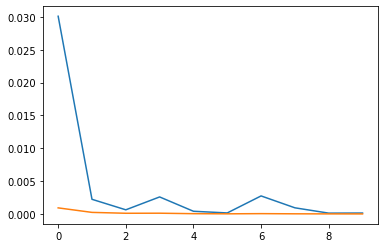

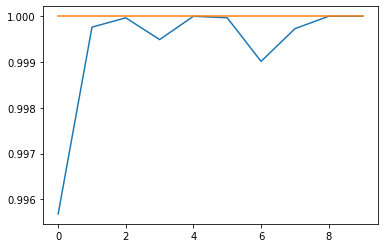

In [26]:

from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()